In [1]:
import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pystan
import seaborn as sns
import scipy as sp

#### Import data

In [2]:
names = ['streams', 'acousticness', 'danceability', 'energy', 'loudness', 'tempo', 'valence']
global_data  = pd.read_csv('./data/global_selected.csv',header=None, names=names)
finland_data = pd.read_csv('./data/finland_selected.csv',header=None, names=names)
sweden_data  = pd.read_csv('./data/sweden_selected.csv',header=None, names=names)

#### Methods for saving and loading models

In [15]:
def save_model(model, filename):
    """Saves the compiled model to file."""
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

def load_model(filename):
    """Load already compiled model from file."""
    return pickle.load(open(filename, 'rb'))

# __Bayesian Inference on Spotify Streams__ | Models
This notebook contains the modeling for our `Bayesian Data Analysis`-course project.
#### This notebook is structured in a following way:
1. __Introducing bayesian linear regression model__
2. __Modeling and inference__ 
    1. 3-covariate model with uninformative priors
    2. 3-covariate model with normal priors
    3. 5-covariate model with normal priors
    4. Extended 5-covariate model with interaction terms
    5. Extended 5-covariate model with interaction terms and hierarchical prior
3. __Model comparison__
4. __Conclusions__


Each model will go through following treatment:     
  * Picking suitable priors
  * Convergence diagnostics
  * Sensitivity analysis
  * Predictive distribution checking
  * Model evaluation


## __1. Introducing Bayesian Linear Regression Model__
#### __Motivation__ 
We are interested in finding out which features in the spotify's song data determine the number of streams in Spotify. We will study this hypothesis by using multiple linear models which model the linear relationship between the variable that includes data about the number of streams with other variables which we use as predictors.

#### __Assumptions__
We first assume that the relationship between $d$-dimension predictor variables $X = \{X_1,X_2,...,X_d\}$ each having $n$ elements, and observations $Y = \{y_1,y_2,...,y_n\}$ (streams) is modeled by *linear dependence*. We also assume that all elements $y \in Y$ and $x \in X$ are independent of each other. 

The mean $\mu$ of model is described by: $\mu = \mathbb{E}[y_i \mid \beta, X] = \alpha + \beta_1 X_1 + \beta_2 X_2 + , ... , + \beta_d X_d$, where $\alpha$ is the intercept and $\beta = \{\beta_1, \beta_2, ... , \beta_d\}$ the parameter vector for coefficients.

We also need to consider the unknown error term $\sigma$. Thus in general form our model is of the form:  

$$\large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_d X_d, \;\sigma)$$

In bayesian context we are not interested about point-estimate per se, but rather the whole posterior distribution which takes the form:

$$\large p(\beta \mid y, X) = \frac{p(y \mid \beta,X)p(\beta\mid X)}{p(y\mid X)}$$

## __2. Modeling and Inference__

## __Uninformative model__ | Three predictors with uninformative priors
For the first model we select three of the predictor variables which in the EDA showed highest linear dependence with $Y$: acousticness, loudness and valence.

Complete model takes the form:

$$ \large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3, \;\sigma)$$


We start the modeling with uninformative priors. This type of simple model gives us a crude picture of what the bayesian inference can tell us about the data, and it gives us a reference model which we can then compare the more complex models on.  
Here we let Stan take care of the priors, and it chooses __*uniform priors by default*__. This is also known as the *ordinary linear regression*:

### __Load model__

In [16]:
filename = 'lin_3_uninformative-2.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // loudness
    vector[N] X3; // valence
    
    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred; 
}

parameters{
    real a;
    vector[3] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3;
}

model{
    y ~ normal(mu, sigma);
}

generated quantities{
    vector[Npred] ypred;
    vector[N] log_lik;
    
    for (j in 1:N){ 
        // logarithmic likelihood for streams (PSIS-LOO)
        log_lik[j] = normal_lpdf(y[j] | mu, sigma);
    }
    
    for (j in 1:Npred){
        // prediction for year 2018
        ypred[j] = normal_rng(a + b[1]*X1pred[j] + b[2]*X2pred[j] + b[3]*X3pred[j], sigma);
    } 
 
}


In [17]:
gb_2017 = global_data.values
gb_2018 = finland_data.values # We need to query the API for 2018 data and pre-process it. Finnish data is used for demonstration. 
data = dict(N=gb_2017.shape[0],y=gb_2017[:,0],X1=gb_2017[:,1], X2=gb_2017[:,4], X3=gb_2017[:,6],
            Npred=gb_2018.shape[0], X1pred=gb_2018[:,1], X2pred=gb_2018[:,4], X3pred=gb_2018[:,6])

### __Fit model__

In [21]:
# Load compiled model if available
fit = None
try:
  fit = load_model('lin_3_uninformative-2.stan.saved')
except Exception: 
  fit = pystan.stan(file=filename, data=data, seed=42)
  save_model(fit, filename + '.saved')

In [39]:
samples = fit.extract(permuted=True)

### __Simulation results__ | Posterior

In [164]:
summary = fit.summary(pars = ['a','b','sigma','ypred',]) 
fit_sum = pd.DataFrame(summary['summary'],
                  index=summary['summary_rownames'],
                  columns = summary['summary_colnames'])

fit_sum.iloc[0:10,0:10]

mean       se_mean            sd          2.5%  \
a         4.042490e+08  2.566760e+05  1.839015e+07  3.679080e+08   
b[1]      1.995867e+07  2.745821e+05  1.911467e+07 -1.758113e+07   
b[2]      1.148006e+07  3.151645e+05  2.030050e+07 -2.900204e+07   
b[3]      1.882070e+07  3.080298e+05  1.973427e+07 -1.866617e+07   
sigma     1.811470e+08  2.029903e+05  1.314068e+07  1.580262e+08   
ypred[1]  5.140647e+08  3.133238e+06  1.973571e+08  1.216547e+08   
ypred[2]  4.484351e+08  2.867415e+06  1.840363e+08  9.282932e+07   
ypred[3]  4.779380e+08  2.968153e+06  1.925233e+08  9.654293e+07   
ypred[4]  3.545502e+08  2.905375e+06  1.817423e+08  1.806482e+05   
ypred[5]  4.252427e+08  2.969616e+06  1.881133e+08  6.041564e+07   

                   25%           50%           75%         97.5%        n_eff  \
a         3.918951e+08  4.041979e+08  4.165687e+08  4.401662e+08  5133.338307   
b[1]      7.102302e+06  1.990952e+07  3.289359e+07  5.666717e+07  4846.065587   
b[2]     -1.887765e+06  1.191536e+07  2.532391e+07  5.099995e+07  4148.957763   
b[3]      5.813855e+06  1.862729e+07  3.169391e+07  5.912330e+07  4104.466549   
sigma     1.721527e+08  1.805049e+08  1.890306e+08  2.089492e+08  4190.688321   
ypred[1]  3.827036e+08  5.172865e+08  6.489398e+08  8.956585e+08  3967.517582   
ypred[2]  3.248934e+08  4.452127e+08  5.713582e+08  8.083527e+08  4119.324948   
ypred[3]  3.490738e+08  4.769098e+08  6.065680e+08  8.573567e+08  4207.207786   
ypred[4]  2.336459e+08  3.509589e+08  4.788190e+08  7.077945e+08  3912.977631   
ypred[5]  3.011409e+08  4.234577e+08  5.497773e+08  8.051036e+08  4012.715245   

              Rhat  
a         0.999153  
b[1]      0.999641  
b[2]      1.000212  
b[3]      1.000082  
sigma     0.999438  
ypred[1]  1.000127  
ypred[2]  1.000484  
ypred[3]  0.999785  
ypred[4]  0.999885  
ypred[5]  1.000194

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ad890c208>,
      dtype=object)

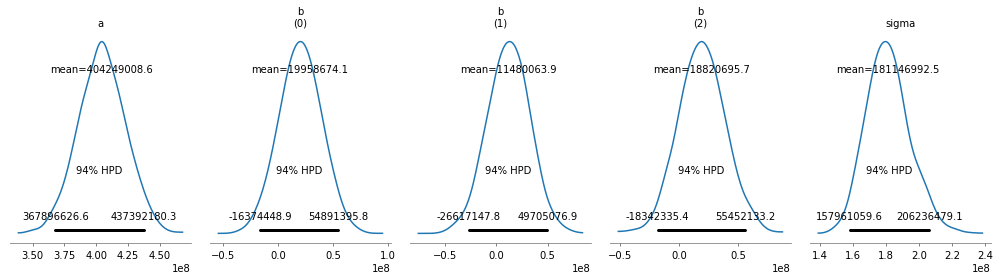

In [148]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood=fit['log_lik'])
azpos = azfit.posterior.drop(['mu','log_lik'])
az.plot_posterior(azpos, figsize=(14,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ad7a6dba8>,
      dtype=object)

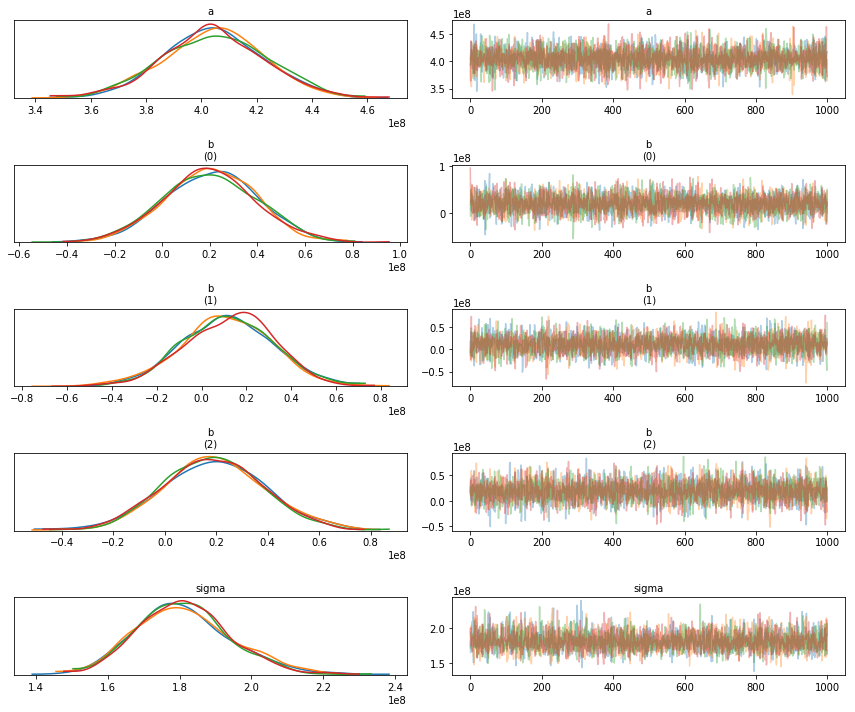

In [172]:
az.plot_trace(azpos)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6ad824bf98>, GridSpec(4, 4))

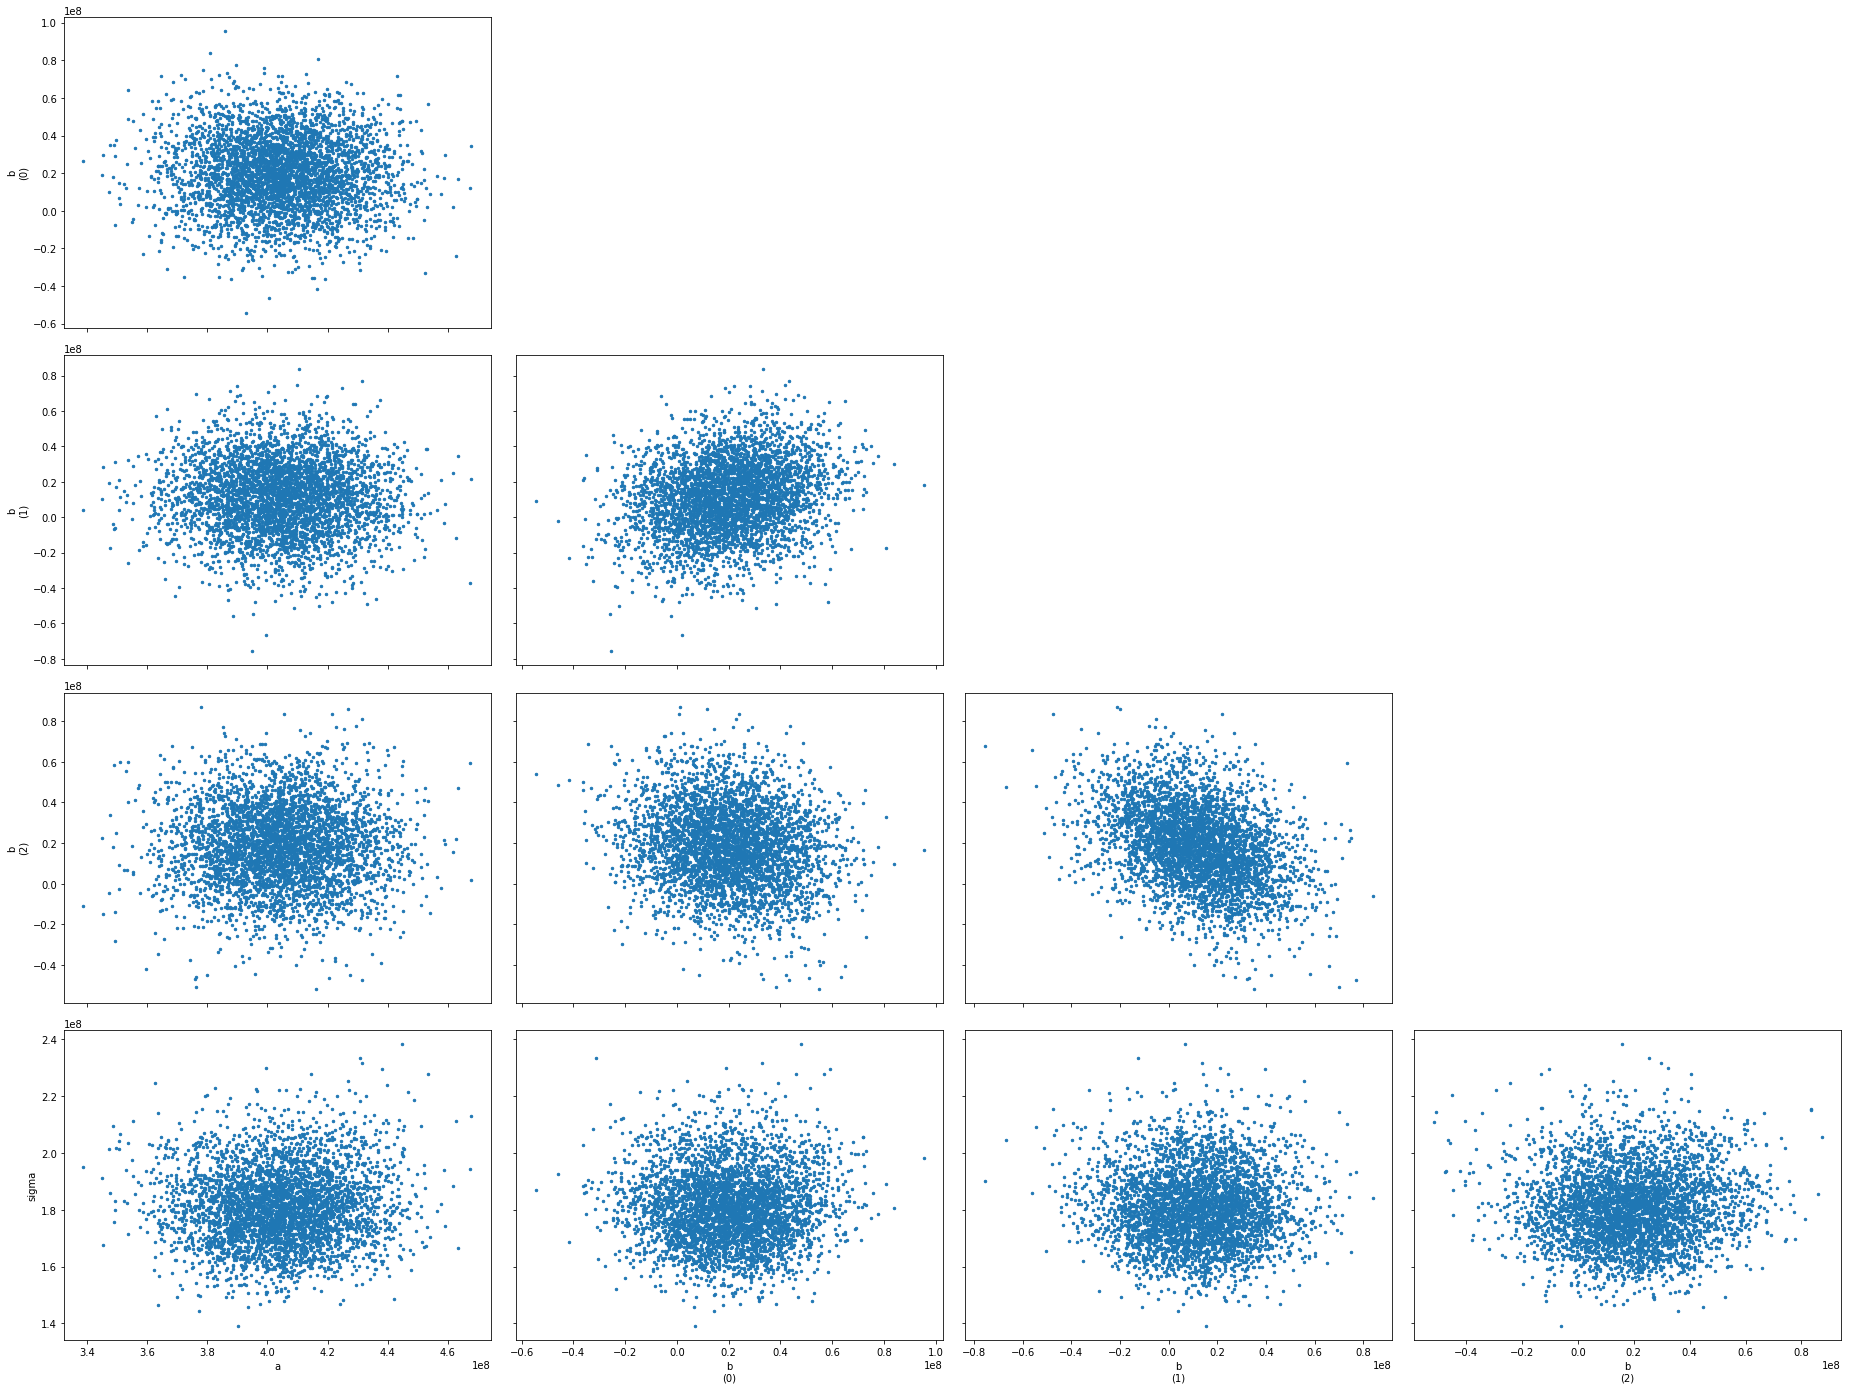

In [149]:
az.plot_pair(azpos)

### __Model check__ | PSIS-LOO

In [108]:
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood=fit['log_lik'])
az.loo(azfit)

/home/zenist/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


ValueError: not enough values to unpack (expected 2, got 1)

### __Predictive accuracy__ | Predict streams for 2018 top 100 

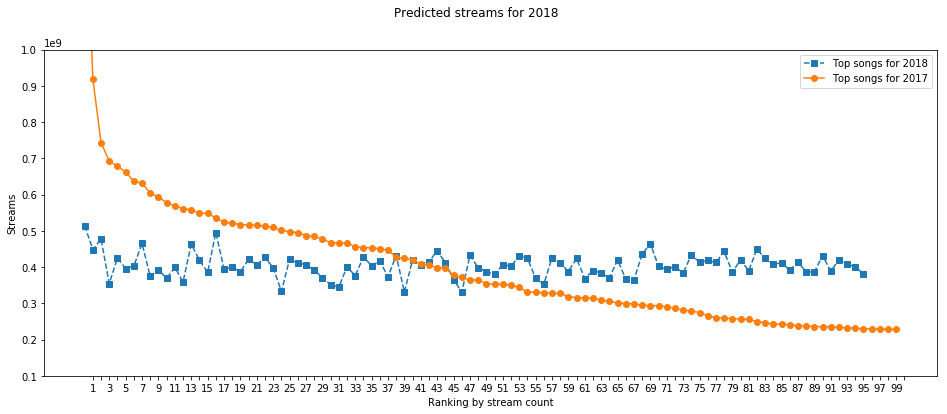

In [161]:
plt.figure(figsize=(16,6))
plt.suptitle('Predicted streams for 2018')
plt.ylim(1e8,10e8)
plt.xticks(range(1,101),labels=['{0}'.format(i) if i % 2 != 0 else '' for i in range(1,101)])
plt.xlabel('Ranking by stream count')
plt.ylabel('Streams')
plt.plot(X[0:96], np.mean(samples['ypred'], axis=0),  's--', label='Top songs for 2018')
plt.plot(X, global_data['streams'], 'o-', label='Top songs for 2017')
plt.legend(loc='best')

## __Informative model__ | Three predictors with normal priors
One of the common priors for linear regression is Zellner's prior with independent Gaussian priors such that for each $j \mid 1 \leq j \leq d$ and $\beta_j \sim N(0, \frac{\sigma^2}{g})$ and often the unit information prior $g = 1 / n$ is used. To see if Zellner is usable, we first visualize the feature distributions:

For the second model we add normal priors, thus making the model normal linear model.
Complete model takes the form:

$$ \large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3, \;\sigma)$$

Now we also assume independent prior distributions for $\alpha$ and $\beta_j$'s such that $\alpha \sim N(\mu_{0a}, \sigma_{0a})$, and $\beta_j \sim N(\mu_{0j}, \sigma_{0j})$, where $1 \leq j \leq 3$.

### __Load model__

In [178]:
filename = 'lin_3_informative.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // loudness
    vector[N] X3; // valence
    
    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred;
    
    // prior means 
    real mu_a;
    vector[3] mu_b;
   
    // prior stds
    real sigma_0;
}

parameters{
    real a;
    vector[3] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3;
}

model{
    a ~ normal(mu_a, sigma_0);
    b ~ normal(mu_b, sigma_0);
    y ~ normal(mu, sigma);
}

generated quantities{
    vector[Npred] ypred;
    vector[N] log_lik;
    
    for (j in 1:N){ 
        // logarithmic likelihood for streams (PSIS-LOO)
        log_lik[j] = normal_lpdf(y[j] | mu, sigma);
    }
    
    for (j in 1:Npred){
        // prediction for year 2018
        ypred[j] = normal_

In [179]:
gb_2017 = global_data.values
gb_2018 = finland_data.values # We need to query the API for 2018 data and pre-process it. Finnish data is used for demonstration. 
data = dict(N=gb_2017.shape[0],y=gb_2017[:,0],X1=gb_2017[:,1], X2=gb_2017[:,4], X3=gb_2017[:,6],
            Npred=gb_2018.shape[0], X1pred=gb_2018[:,1], X2pred=gb_2018[:,4], X3pred=gb_2018[:,6],
            mu_a=0,
            mu_b=[0,0,0],
            sigma_0=4e8) # Approximately the first model's result for std of priors x 2

### __Fit model__

In [180]:
# Load compiled model if available
fit = None
try:
  fit = load_model('lin_3_informative.stan')
except Exception: 
  fit = pystan.stan(file=filename, data=data, seed=42)
  save_model(fit, filename + '.saved')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b307a67678da5ca7b10655f48752864b NOW.
/home/zenist/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  after removing the cwd from sys.path.


In [181]:
samples = fit.extract(permuted=True)

### __Simulation results__ | Posterior

In [182]:
summary = fit.summary(pars = ['a','b','sigma','ypred',]) 
fit_sum = pd.DataFrame(summary['summary'],
                  index=summary['summary_rownames'],
                  columns = summary['summary_colnames'])

fit_sum.iloc[0:10,0:10]

mean       se_mean            sd          2.5%  \
a         4.029202e+08  2.542773e+05  1.853423e+07  3.671759e+08   
b[1]      1.967418e+07  2.685750e+05  1.868957e+07 -1.663731e+07   
b[2]      1.155158e+07  3.507051e+05  2.057402e+07 -2.823923e+07   
b[3]      1.874319e+07  3.261711e+05  2.068316e+07 -2.286830e+07   
sigma     1.810676e+08  2.132455e+05  1.335133e+07  1.568133e+08   
ypred[1]  5.134727e+08  3.029160e+06  1.962187e+08  1.236063e+08   
ypred[2]  4.398383e+08  2.885234e+06  1.841614e+08  9.187761e+07   
ypred[3]  4.808934e+08  3.163906e+06  1.912505e+08  1.031378e+08   
ypred[4]  3.586379e+08  2.806576e+06  1.857563e+08 -6.416228e+06   
ypred[5]  4.207537e+08  2.883624e+06  1.826156e+08  6.309507e+07   

                   25%           50%           75%         97.5%        n_eff  \
a         3.902819e+08  4.026969e+08  4.158436e+08  4.393067e+08  5312.928284   
b[1]      6.677712e+06  1.982368e+07  3.219492e+07  5.615118e+07  4842.475442   
b[2]     -2.451680e+06  1.143506e+07  2.544290e+07  5.226724e+07  3441.550601   
b[3]      5.247858e+06  1.863988e+07  3.273778e+07  5.876173e+07  4021.078755   
sigma     1.717267e+08  1.803776e+08  1.894047e+08  2.097704e+08  3920.030137   
ypred[1]  3.852677e+08  5.123166e+08  6.461436e+08  9.049342e+08  4196.010486   
ypred[2]  3.098590e+08  4.396125e+08  5.647957e+08  7.987701e+08  4074.132266   
ypred[3]  3.512278e+08  4.815044e+08  6.083859e+08  8.545148e+08  3653.910451   
ypred[4]  2.367815e+08  3.561906e+08  4.808588e+08  7.253604e+08  4380.599590   
ypred[5]  3.018754e+08  4.218675e+08  5.428363e+08  7.811875e+08  4010.499599   

              Rhat  
a         1.000350  
b[1]      1.000375  
b[2]      1.001781  
b[3]      1.001093  
sigma     1.000295  
ypred[1]  1.001164  
ypred[2]  0.999681  
ypred[3]  1.000465  
ypred[4]  0.999786  
ypred[5]  0.999877

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ad85ad5f8>,
      dtype=object)

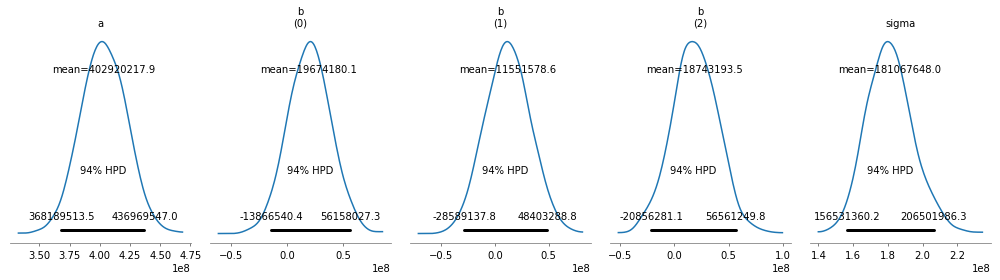

In [183]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood=fit['log_lik'])
azpos = azfit.posterior.drop(['mu','log_lik'])
az.plot_posterior(azpos, figsize=(14,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ad76efe80>,
      dtype=object)

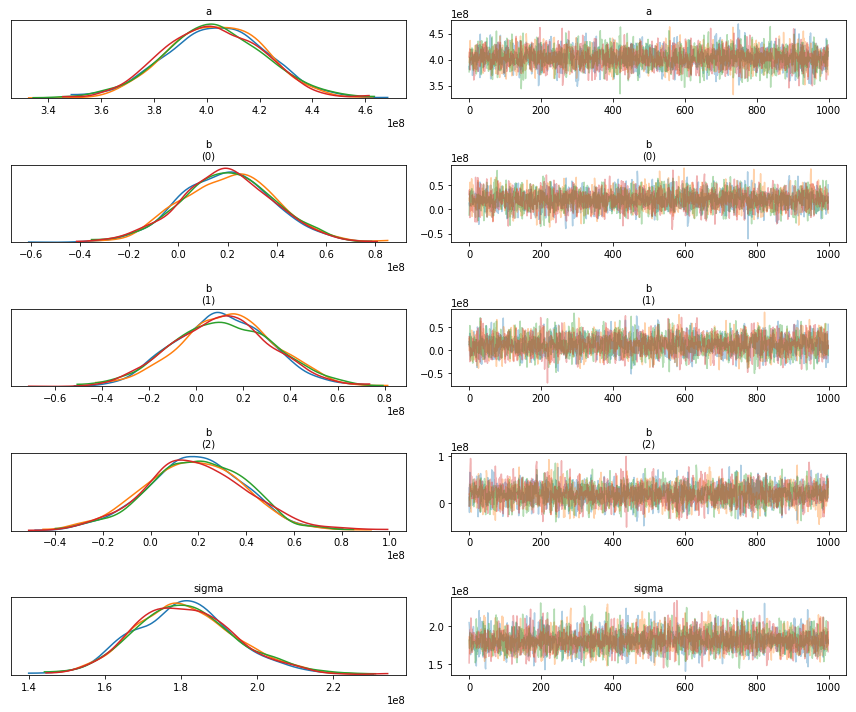

In [184]:
az.plot_trace(azpos)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6ad282aef0>, GridSpec(4, 4))

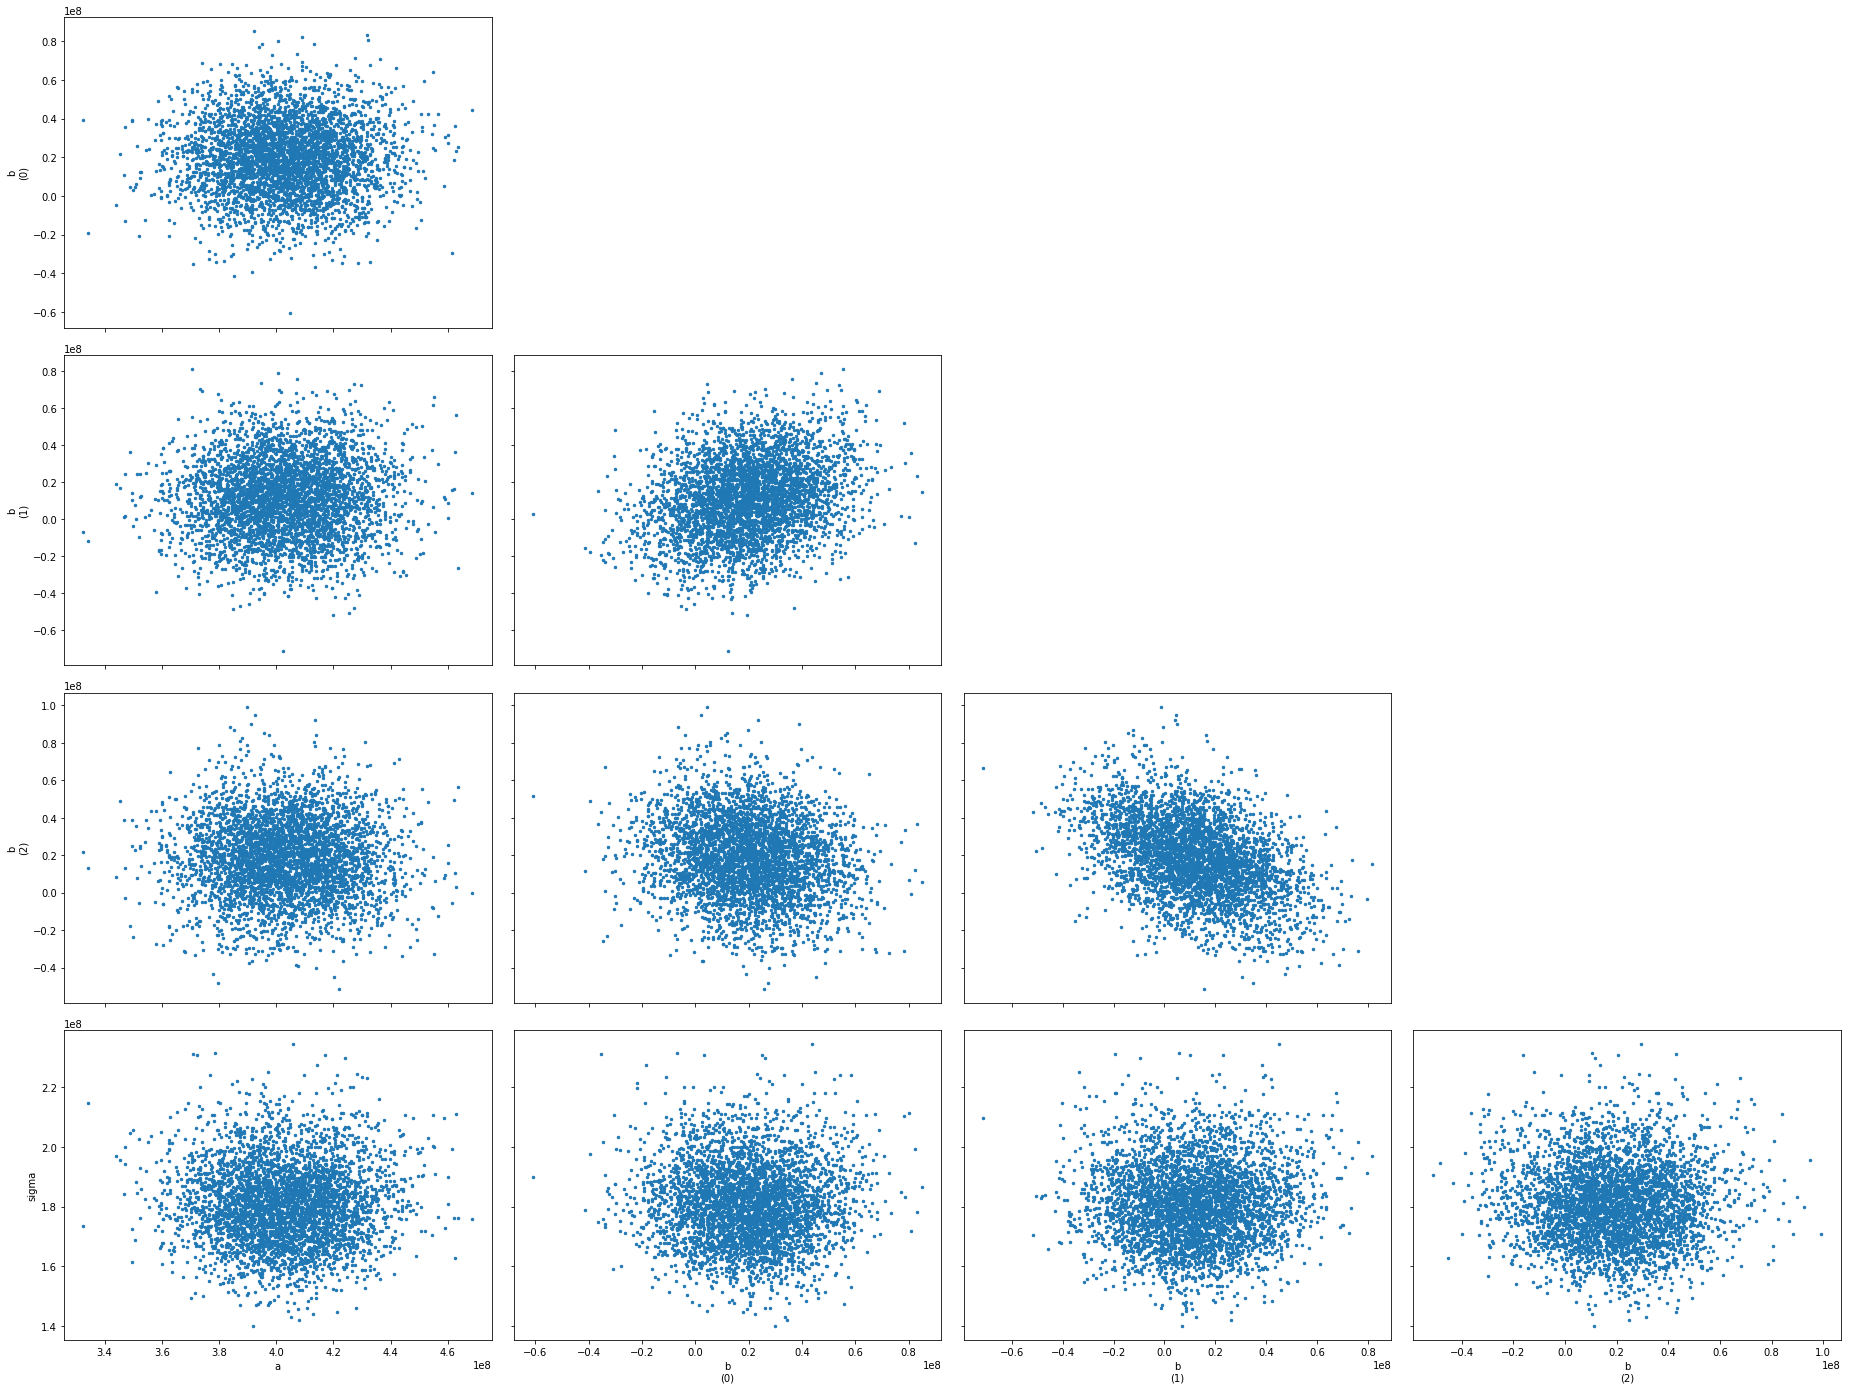

In [185]:
az.plot_pair(azpos)

### __Model check__ | PSIS-LOO

In [186]:
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood=fit['log_lik'])
az.loo(azfit)

/home/zenist/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


ValueError: not enough values to unpack (expected 2, got 1)

### __Predictive accuracy__ | Predict streams for 2018 top 100 

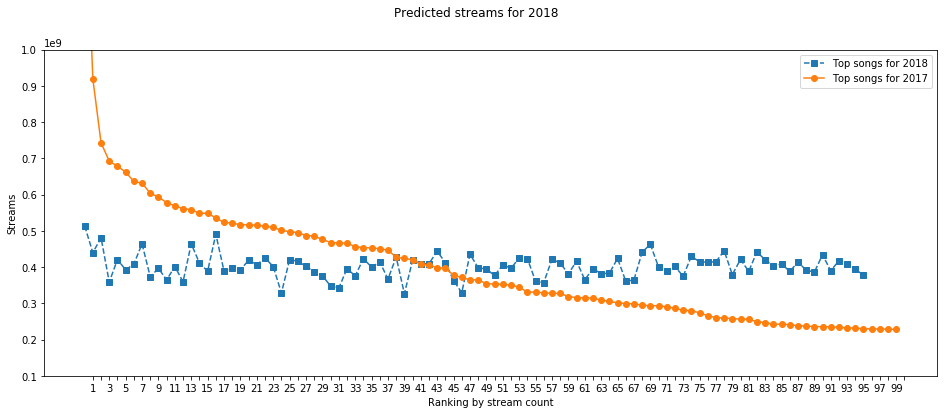

In [187]:
plt.figure(figsize=(16,6))
plt.suptitle('Predicted streams for 2018')
plt.ylim(1e8,10e8)
plt.xticks(range(1,101),labels=['{0}'.format(i) if i % 2 != 0 else '' for i in range(1,101)])
plt.xlabel('Ranking by stream count')
plt.ylabel('Streams')
plt.plot(X[0:96], np.mean(samples['ypred'], axis=0),  's--', label='Top songs for 2018')
plt.plot(X, global_data['streams'], 'o-', label='Top songs for 2017')
plt.legend(loc='best')

## __Informative model__ | Five predictors with normal priors
In hope of better results, we will extend the model to include other covariates except energy which based on the exploratory data analysis is strongly collinear with 'loudness' and thus would not satisfy the linearity assumptions of our model. 

Third model will have 5 predictors with normal priors.
Complete model takes the form:

$$ \large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4 + \beta_5 X_5, \;\sigma)$$

We also extend our priors accordingly.

### __Load model__

In [194]:
filename = 'lin_5_informative.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // loudness
    vector[N] X4; // tempo
    vector[N] X5; // valence

    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred;
    vector[Npred] X4pred;
    vector[Npred] X5pred;
    
    // prior means 
    real mu_a;
    vector[5] mu_b;
   
    // prior stds
    real sigma_0;
}

parameters{
    real a;
    vector[5] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3 + b[4]*X4 + b[5]*X5;
}

model{
    a ~ normal(mu_a, sigma_0);
    b ~ normal(mu_b, sigma_0);    
    y ~ normal(mu, sigma);
}

generated quantities{
    vector[Npred] ypred;
    vector[N] log_lik;
    
    for (j in 1:N){ 
        // logarithmic likelihood for streams (PSIS-LOO)
        log_lik[

In [197]:
gb_2017 = global_data.values
gb_2018 = finland_data.values # We need to query the API for 2018 data and pre-process it. Finnish data is used for demonstration. 
data = dict(N=gb_2017.shape[0],
            y=gb_2017[:,0],
            X1=gb_2017[:,1], X2=gb_2017[:,2], X3=gb_2017[:,4], X4=gb_2017[:,5], X5=gb_2017[:,6],
            Npred=gb_2018.shape[0], 
            X1pred=gb_2018[:,1], X2pred=gb_2018[:,2], X3pred=gb_2018[:,4], X4pred=gb_2018[:,5], X5pred=gb_2018[:,6],
            mu_a=0,
            mu_b=[0,0,0,0,0],
            sigma_0=4e8) # Approximately the first model's result for std of priors x 2

### __Fit model__

In [253]:
# Load compiled model if available
fit = None
try:
  fit = load_model('lin_5_informative.stan.saved')
except Exception: 
  fit = pystan.stan(file=filename, data=data, seed=42)
  save_model(fit, filename + '.saved')

In [254]:
samples = fit.extract(permuted=True)

### __Simulation results__ | Posterior

In [255]:
summary = fit.summary(pars = ['a','b','sigma','ypred',]) 
fit_sum = pd.DataFrame(summary['summary'],
                  index=summary['summary_rownames'],
                  columns = summary['summary_colnames'])

fit_sum.iloc[0:10,0:10]

mean       se_mean            sd          2.5%  \
a         4.032001e+08  2.208970e+05  1.807570e+07  3.677297e+08   
b[1]      2.014115e+07  2.802483e+05  1.948095e+07 -1.799133e+07   
b[2]     -7.365736e+06  3.342279e+05  2.146668e+07 -4.954299e+07   
b[3]      1.147267e+07  3.281229e+05  2.072441e+07 -2.866844e+07   
b[4]      1.474255e+07  2.835542e+05  2.003528e+07 -2.480317e+07   
b[5]      2.315606e+07  3.303398e+05  2.177549e+07 -2.054940e+07   
sigma     1.818533e+08  1.909305e+05  1.311852e+07  1.583772e+08   
ypred[1]  4.982848e+08  3.127962e+06  1.961160e+08  1.132789e+08   
ypred[2]  4.829043e+08  2.922971e+06  1.875822e+08  1.143017e+08   
ypred[3]  5.216799e+08  3.224927e+06  2.019928e+08  1.396168e+08   

                   25%           50%           75%         97.5%        n_eff  \
a         3.912513e+08  4.033037e+08  4.153542e+08  4.384572e+08  6695.928285   
b[1]      6.633073e+06  2.024885e+07  3.337723e+07  5.818635e+07  4832.084449   
b[2]     -2.173191e+07 -7.719809e+06  7.174051e+06  3.454662e+07  4125.193513   
b[3]     -2.688047e+06  1.158131e+07  2.535021e+07  5.233984e+07  3989.250659   
b[4]      1.190271e+06  1.502508e+07  2.817029e+07  5.439383e+07  4992.508067   
b[5]      9.177776e+06  2.289579e+07  3.742271e+07  6.524966e+07  4345.245529   
sigma     1.725717e+08  1.809708e+08  1.899865e+08  2.100378e+08  4720.841071   
ypred[1]  3.686978e+08  4.974037e+08  6.302134e+08  8.824061e+08  3930.998821   
ypred[2]  3.584424e+08  4.832356e+08  6.073411e+08  8.463111e+08  4118.454885   
ypred[3]  3.877209e+08  5.229652e+08  6.545421e+08  9.158156e+08  3923.124760   

              Rhat  
a         0.999315  
b[1]      0.999282  
b[2]      0.999923  
b[3]      1.000169  
b[4]      1.000140  
b[5]      0.999619  
sigma     0.999390  
ypred[1]  1.000067  
ypred[2]  1.000264  
ypred[3]  1.000182

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6aba361940>,
      dtype=object)

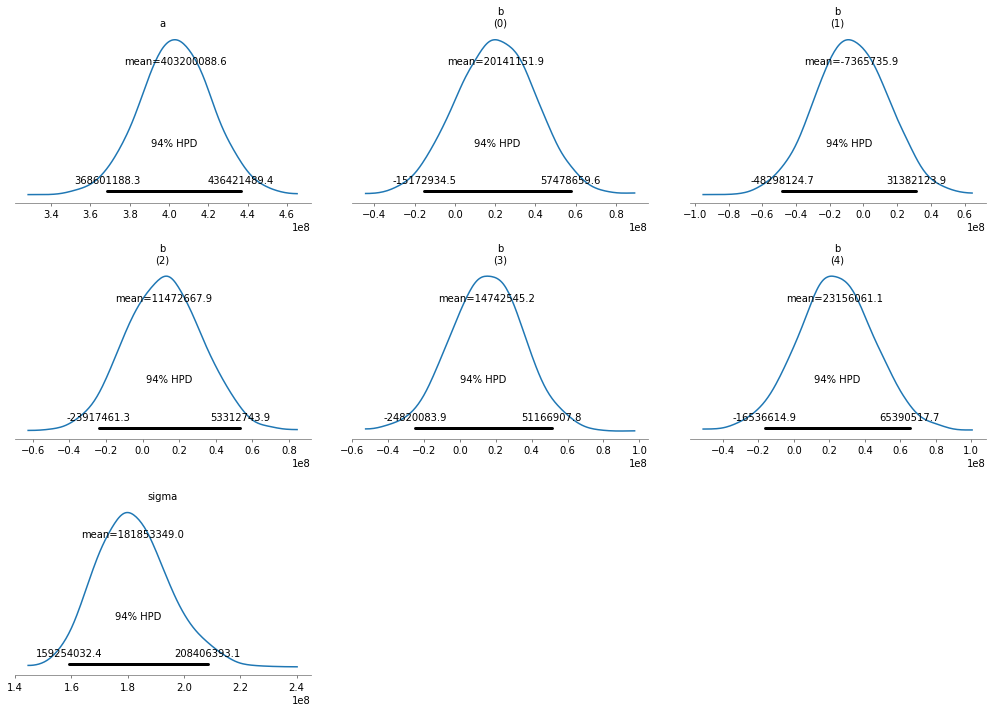

In [256]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood=fit['log_lik'])
azpos = azfit.posterior.drop(['mu','log_lik'])
az.plot_posterior(azpos, figsize=(14,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ad5529358>,
      dtype=object)

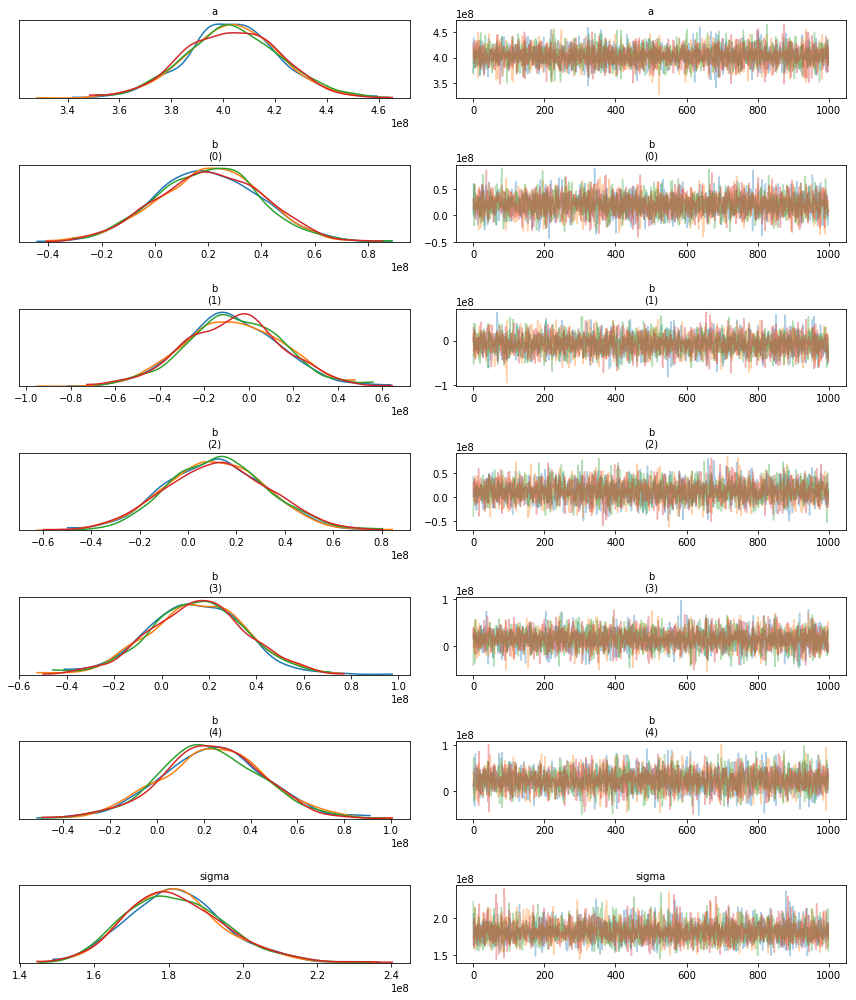

In [202]:
az.plot_trace(azpos)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6ad4c6dbe0>, GridSpec(6, 6))

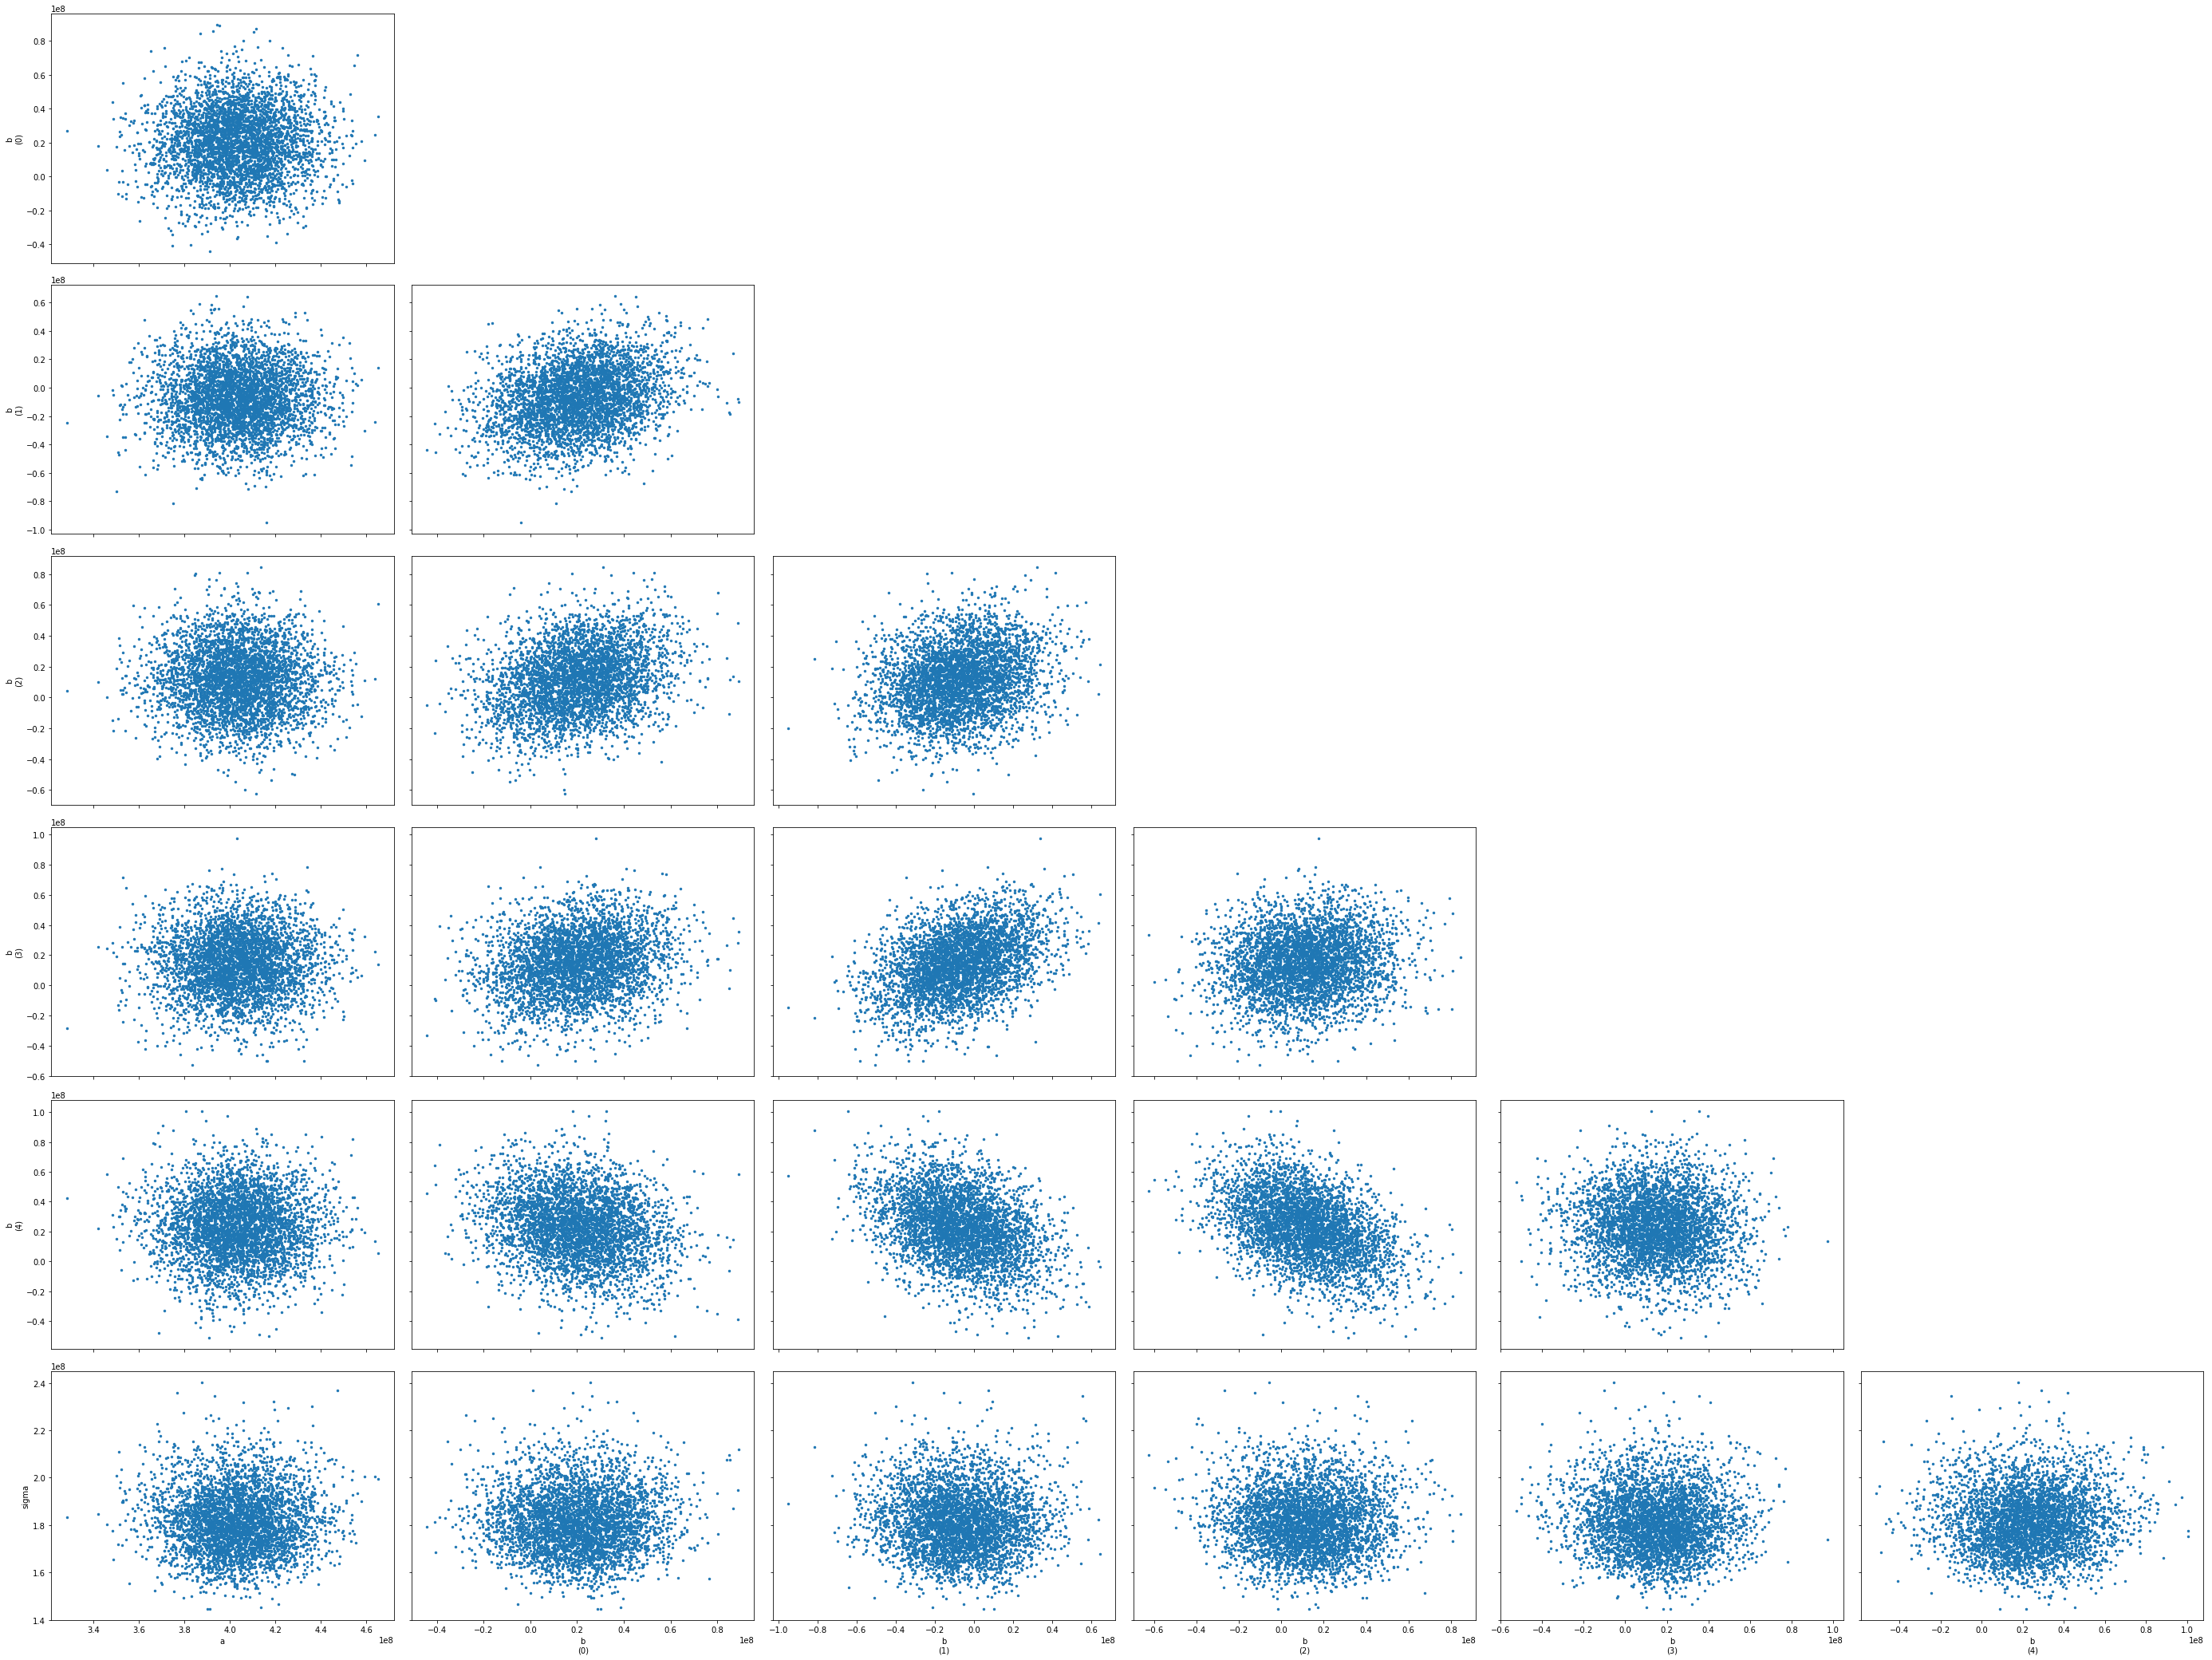

In [203]:
az.plot_pair(azpos)

### __Model check__ | PSIS-LOO

In [204]:
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood=fit['log_lik'])
az.loo(azfit)

/home/zenist/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


ValueError: not enough values to unpack (expected 2, got 1)

### __Predictive accuracy__ | Predict streams for 2018 top 100 

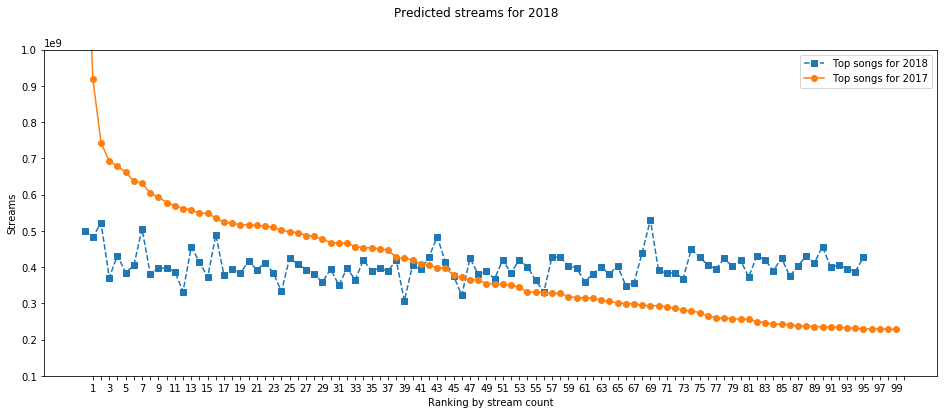

In [205]:
plt.figure(figsize=(16,6))
plt.suptitle('Predicted streams for 2018')
plt.ylim(1e8,10e8)
plt.xticks(range(1,101),labels=['{0}'.format(i) if i % 2 != 0 else '' for i in range(1,101)])
plt.xlabel('Ranking by stream count')
plt.ylabel('Streams')
plt.plot(X[0:96], np.mean(samples['ypred'], axis=0),  's--', label='Top songs for 2018')
plt.plot(X, global_data['streams'], 'o-', label='Top songs for 2017')
plt.legend(loc='best')

## __Extended model__ | Adding interaction terms
In the exploratory data analysis part of this analysis we identified multiple potential collinear relationships between covariates. We will now relax the linearity assumption of the model and introduce two new interaction term which will model the potential positive collinearity between `valence` and `loudness`, and negative collinearity between `tempo` and `danceability`.

This model will have 5 predictors with normal priors and altogether 7 parameters.
Complete model takes the form:

$$ \large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4 + \beta_5 X_5 + \beta_6 X_2 X_4 + \beta_7 X_3 X_5, \;\sigma)$$

We also extend our priors accordingly.

### __Load model__

In [231]:
filename = 'lin_5_informative-interaction.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // loudness
    vector[N] X4; // tempo
    vector[N] X5; // valence

    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred;
    vector[Npred] X4pred;
    vector[Npred] X5pred;
    
    // prior means 
    real mu_a;
    vector[7] mu_b;
   
    // prior stds
    real sigma_0;
}

parameters{
    real a;
    vector[7] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    vector[N] X2X4;
    vector[N] X3X5;
    
    X2X4 = X2 .* X4;
    X3X5 = X3 .* X5;
    
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3 + b[4]*X4 + b[5]*X5 + b[6]*X2X4 + b[7]*X3X5;
}

model{
    a ~ normal(mu_a, sigma_0);
    b ~ normal(mu_b, sigma_0);
    y ~ normal(mu, sigma);
}

generated quantities{
    vector[Npred] ypred;
    vector

In [232]:
gb_2017 = global_data.values
gb_2018 = finland_data.values # We need to query the API for 2018 data and pre-process it. Finnish data is used for demonstration. 
data = dict(N=gb_2017.shape[0],
            y=gb_2017[:,0],
            X1=gb_2017[:,1], X2=gb_2017[:,2], X3=gb_2017[:,4], X4=gb_2017[:,5], X5=gb_2017[:,6],
            Npred=gb_2018.shape[0], 
            X1pred=gb_2018[:,1], X2pred=gb_2018[:,2], X3pred=gb_2018[:,4], X4pred=gb_2018[:,5], X5pred=gb_2018[:,6],
            mu_a=0,
            mu_b=[0,0,0,0,0,0,0],
            sigma_0=4e8) # Approximately the first model's result for std of priors x 2

### __Fit model__

In [233]:
# Load compiled model if available
fit = None
try:
  fit = load_model('lin_5_informative-interaction.stan')
except Exception: 
  fit = pystan.stan(file=filename, data=data, seed=42)
  save_model(fit, filename + '.saved')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9f4667fcc74979b58171eacadb9ab02d NOW.
/home/zenist/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  after removing the cwd from sys.path.


In [234]:
samples = fit.extract(permuted=True)

### __Simulation results__ | Posterior

In [235]:
summary = fit.summary(pars = ['a','b','sigma','ypred',]) 
fit_sum = pd.DataFrame(summary['summary'],
                  index=summary['summary_rownames'],
                  columns = summary['summary_colnames'])

fit_sum.iloc[0:10,0:10]

mean       se_mean            sd          2.5%  \
a         3.977397e+08  2.841603e+05  2.002090e+07  3.573499e+08   
b[1]      2.125894e+07  2.823452e+05  1.890348e+07 -1.479408e+07   
b[2]     -1.372202e+07  3.635684e+05  2.286417e+07 -5.912501e+07   
b[3]      1.950429e+07  3.600534e+05  2.083782e+07 -2.206977e+07   
b[4]      3.243472e+07  3.245161e+05  2.125056e+07 -8.741971e+06   
b[5]      2.401216e+07  3.537530e+05  2.136747e+07 -1.679065e+07   
b[6]      2.438581e+07  2.494829e+05  1.637312e+07 -8.568204e+06   
b[7]      3.738385e+07  2.486640e+05  1.802747e+07  3.454951e+05   
sigma     1.784483e+08  1.913936e+05  1.349918e+07  1.547965e+08   
ypred[1]  5.639721e+08  3.091867e+06  1.998367e+08  1.665360e+08   

                   25%           50%           75%         97.5%        n_eff  \
a         3.845735e+08  3.973903e+08  4.117148e+08  4.358124e+08  4964.098468   
b[1]      8.170124e+06  2.114574e+07  3.399217e+07  5.819974e+07  4482.528432   
b[2]     -2.933855e+07 -1.340880e+07  1.804779e+06  3.111674e+07  3954.928911   
b[3]      5.632760e+06  1.982086e+07  3.340720e+07  6.028299e+07  3349.428895   
b[4]      1.836833e+07  3.245010e+07  4.664813e+07  7.510906e+07  4288.134887   
b[5]      9.709068e+06  2.347710e+07  3.861169e+07  6.564500e+07  3648.429469   
b[6]      1.353170e+07  2.447977e+07  3.560218e+07  5.614117e+07  4307.065280   
b[7]      2.550713e+07  3.766030e+07  4.938355e+07  7.272007e+07  5255.861603   
sigma     1.686837e+08  1.777560e+08  1.869027e+08  2.061858e+08  4974.623446   
ypred[1]  4.345403e+08  5.638304e+08  6.960693e+08  9.636708e+08  4177.426284   

              Rhat  
a         0.999554  
b[1]      1.000400  
b[2]      0.999238  
b[3]      1.000339  
b[4]      1.000533  
b[5]      0.999353  
b[6]      0.999884  
b[7]      0.999500  
sigma     0.999183  
ypred[1]  1.000329

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6aba3710b8>,
      dtype=object)

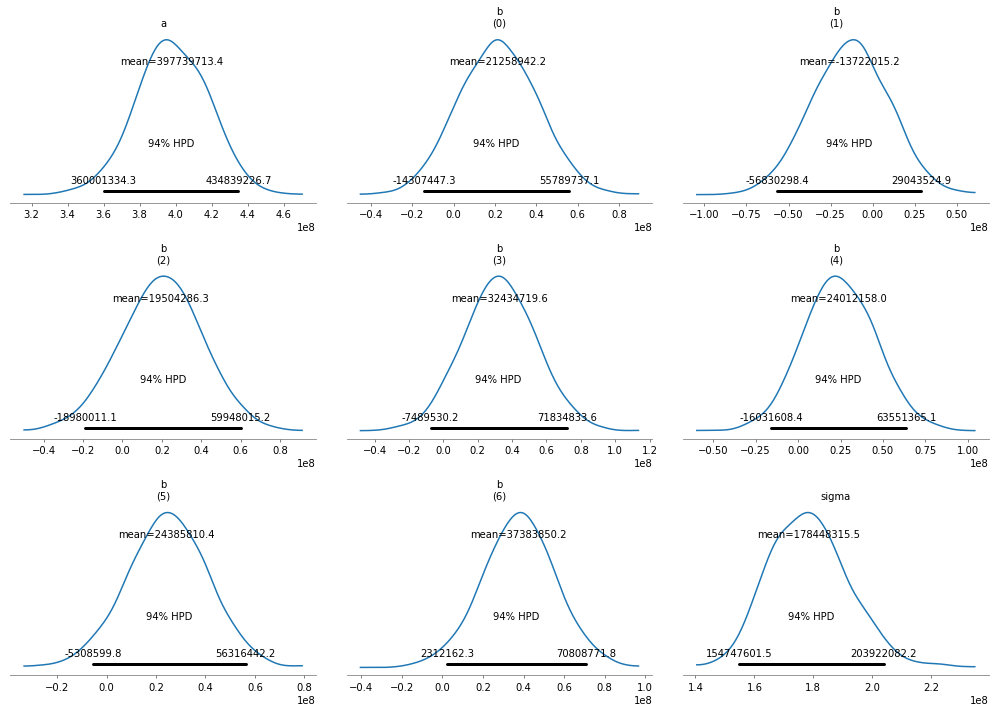

In [246]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood=fit['log_lik'])
azpos = azfit.posterior[['a','b','sigma']]
az.plot_posterior(azpos, figsize=(14,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6aba0cf208>,
      dtype=object)

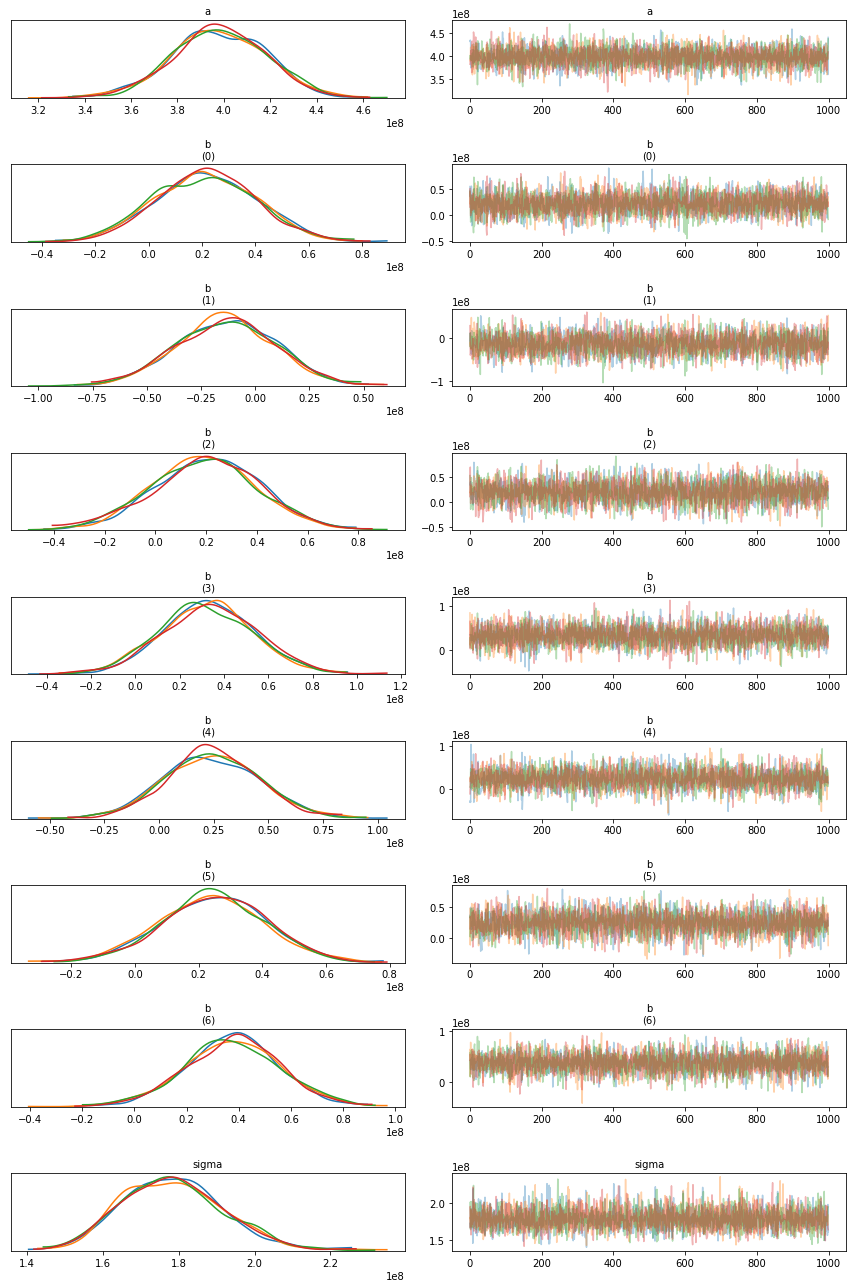

In [247]:
az.plot_trace(azpos)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6ab93ccb38>, GridSpec(8, 8))

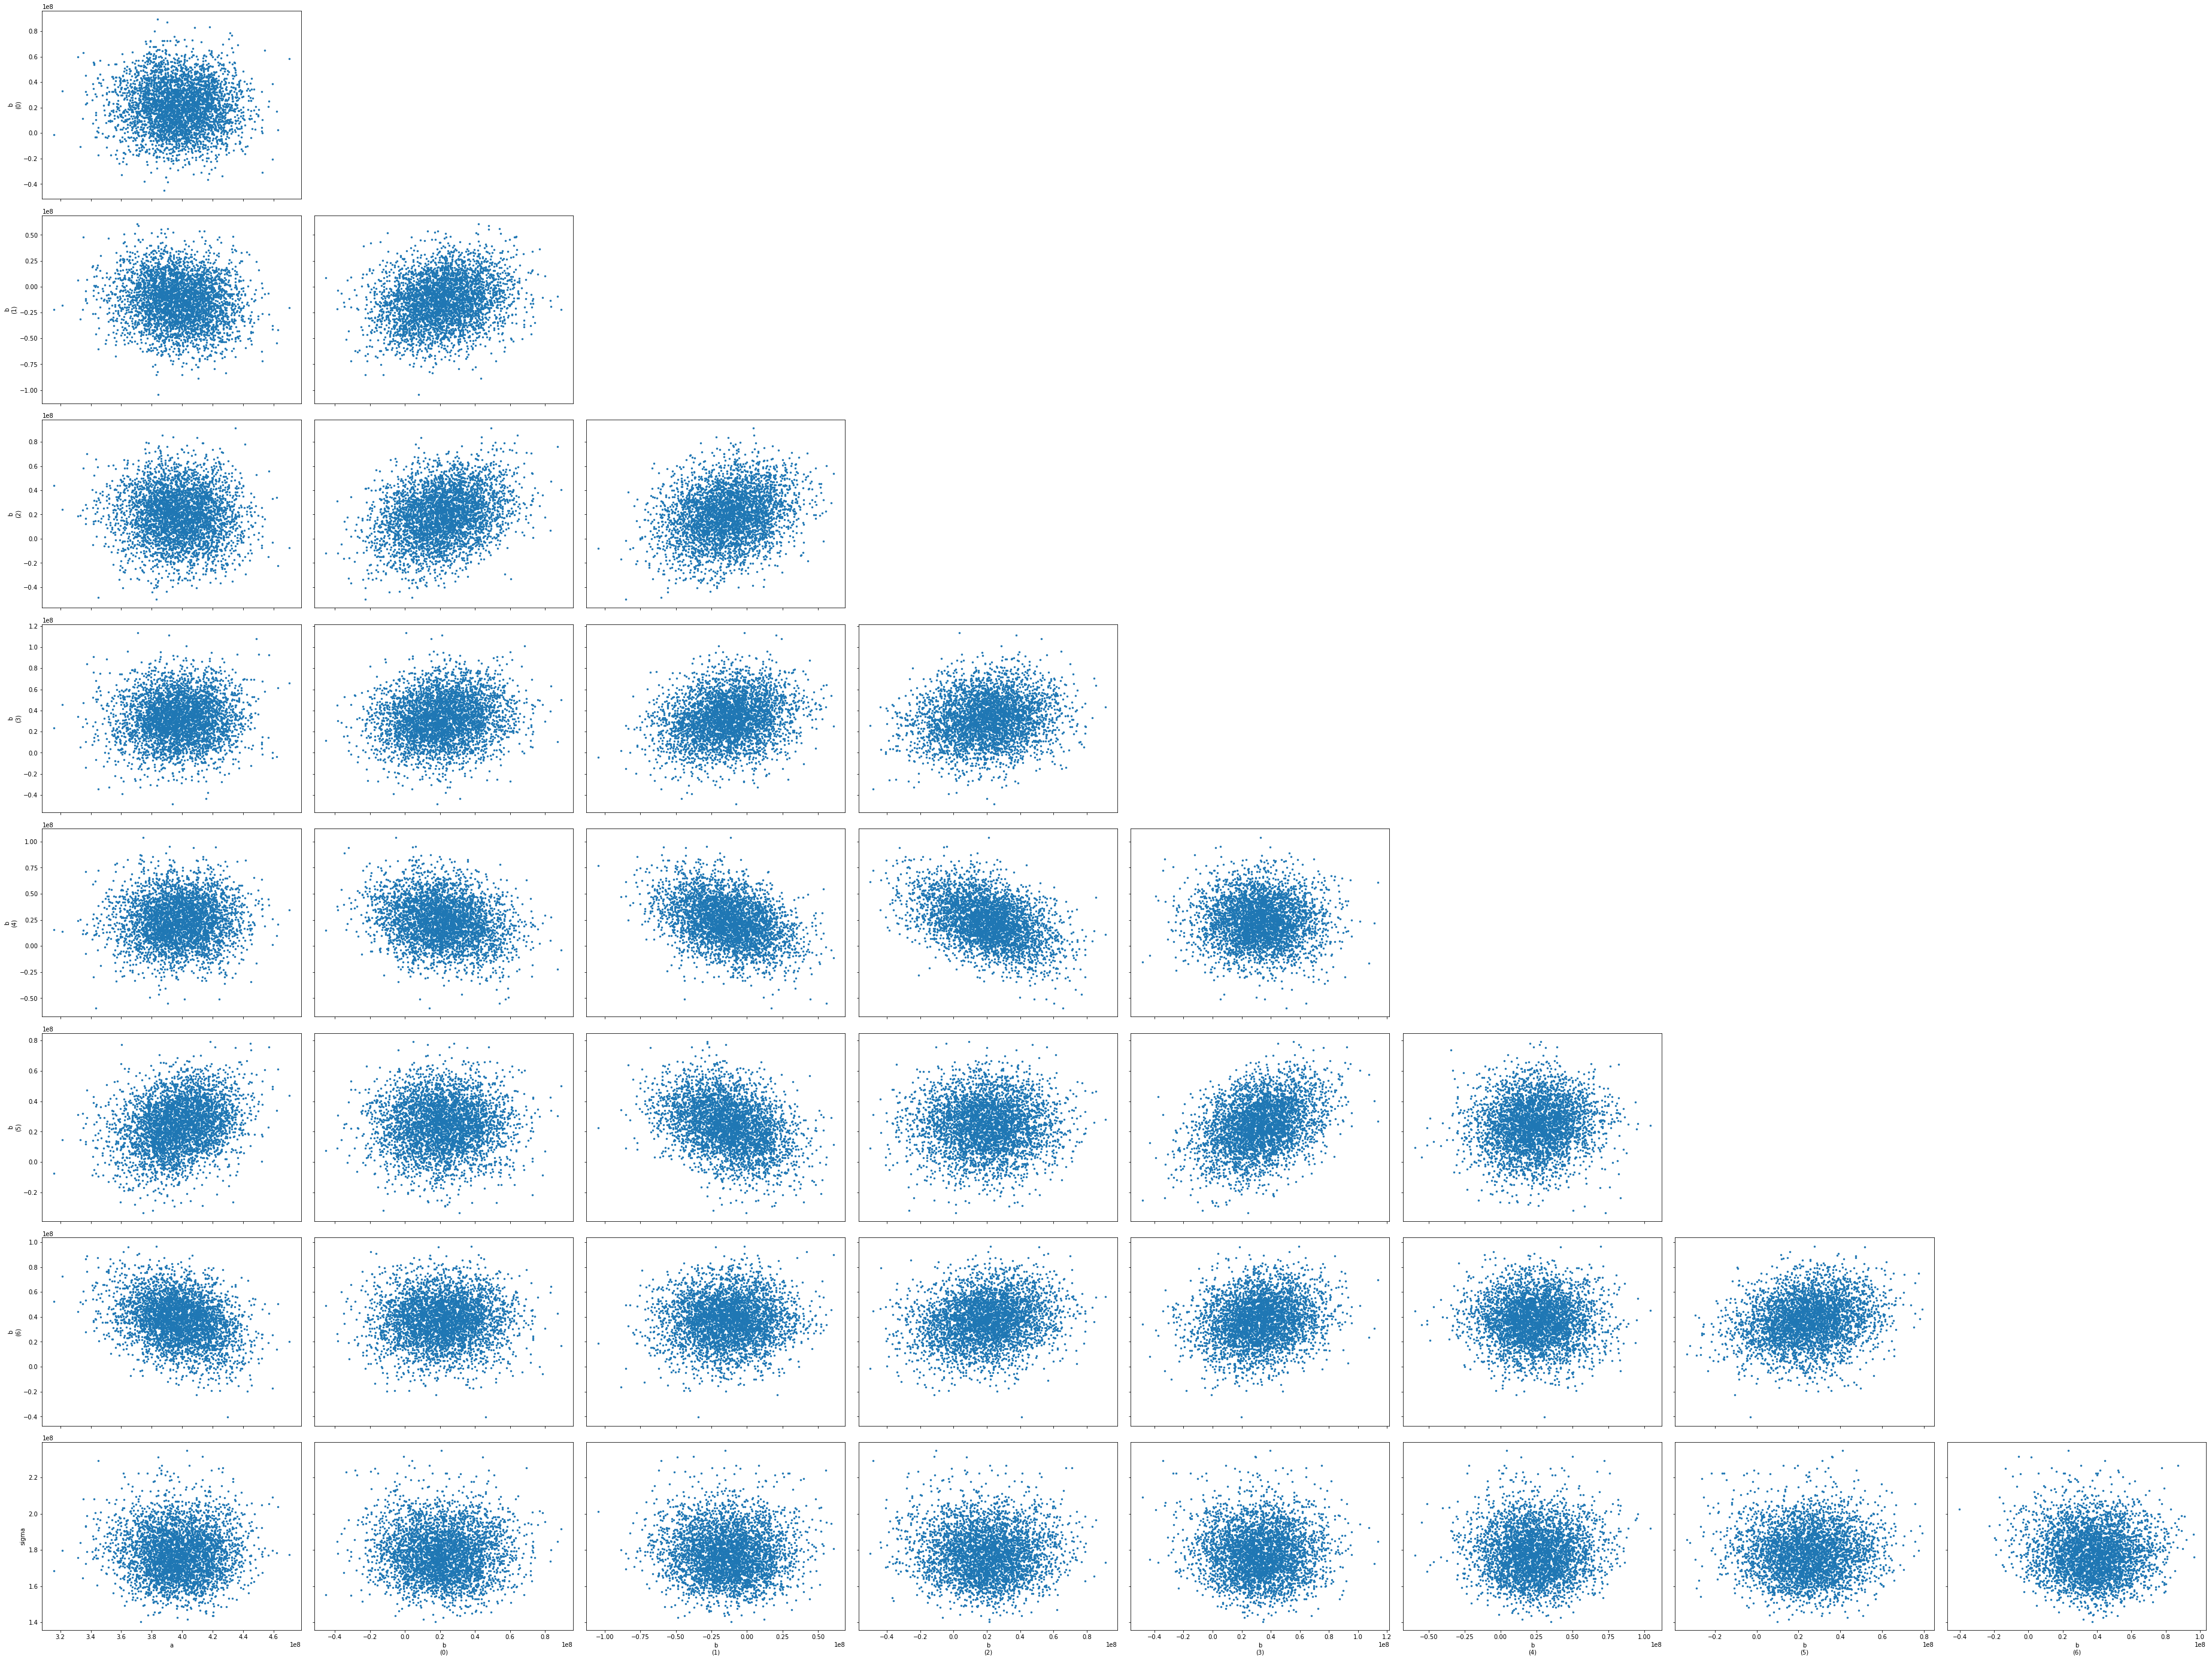

In [248]:
az.plot_pair(azpos)

### __Model check__ | PSIS-LOO

In [249]:
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood='log_lik')
az.loo(azfit)

/home/zenist/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
/home/zenist/anaconda3/lib/python3.6/site-packages/arviz/stats/diagnostics.py:140: RuntimeWarning: invalid value encountered in true_divide
  acorr /= acorr[0]
/home/zenist/anaconda3/lib/python3.6/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highl

loo       loo_se        p_loo  warning
0  419048.612923  5981.727515  7481.317993        1

### __Predictive accuracy__ | Predict streams for 2018 top 100 

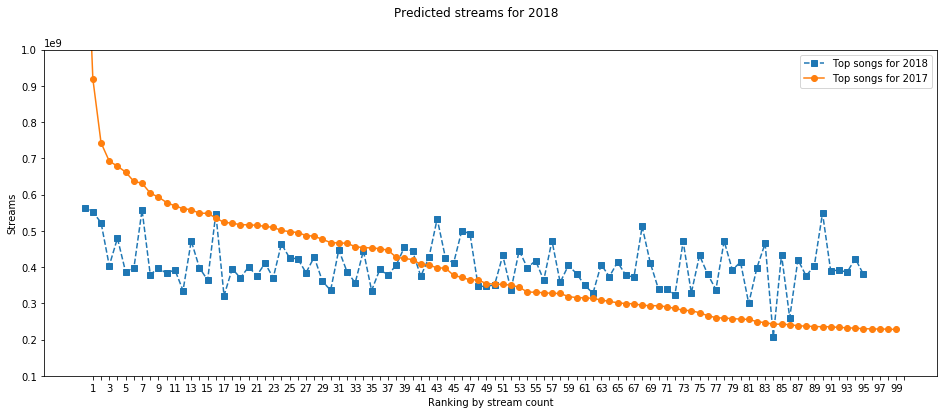

In [250]:
plt.figure(figsize=(16,6))
plt.suptitle('Predicted streams for 2018')
plt.ylim(1e8,10e8)
plt.xticks(range(1,101),labels=['{0}'.format(i) if i % 2 != 0 else '' for i in range(1,101)])
plt.xlabel('Ranking by stream count')
plt.ylabel('Streams')
plt.plot(X[0:96], np.mean(samples['ypred'], axis=0),  's--', label='Top songs for 2018')
plt.plot(X, global_data['streams'], 'o-', label='Top songs for 2017')
plt.legend(loc='best')

## __3. Model Comparison__
Load all models.


Use leave-one-out cross validation (LOO-CV) to assess the predictive performance of the different models.

>* PSIS-LOO values, the effective number of parameters peff , and the k-values for each of the
three models

>* an assessment of how reliable the PSIS-LOO estimates are for the three models based on
the k-values

>* an assessment of whether there are differences between the models, and if so, which model
should be selected according to PSIS-LOO

>* number of effective parameters

## __4. Conclusions__
>  Even the coin tosses and die rolls ubiquitous in probability theory texts are not truly exchangeable. The more relevant question is, ‘Do the model’s deficiencies have a noticeable effect on the substantive inferences?’
p 142


>More formally, we can check a model by external validation using the model to make predic-
tions about future data, and then collecting those data and comparing to their predictions.
Posterior means should be correct on average, 50% intervals should contain the true values
half the time, and so forth. p. 143

See the hierarchical regression model: 142->

__Notes:__
Would the results be easier to interpret if we would normalize the streams to interval [0,1]?

We need to conduct proper sensitivity analysis using different priors and try to develop intuition about the data / hypothesize with more clarity. How to formulate reasonable priors for quite arbitrary linear coefficients $\beta$? Explaining the steepness of slope... 

Also we should think about how to construct hierarchical priors based on earlier data (weekly top 100). Also develop understanding about the make-up off global data - differing countries with differing cultures. For example chinese or italian music could be quite different compared to UK music. We should also train on Finnish and Swedish data and compare cultural differences by comparing posteriors. 